# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [1]:
#| default_exp ffp

In [ ]:
#| hide
from nbdev.showdoc import *

In [1]:
#| export
from LensCalcPy.parameters import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| export
class Ffp:
    """A class to represent a FFP population"""

    

In [4]:
#| export
# from below 16 of https://iopscience.iop.org/article/10.3847/1538-4357/ac07a8/pdf*)
# alphabar = 27 Degrees xp-axis is aligned with the major axis
# of the Galactic bar,where \[Alpha]bar=27\[Degree] is applied as the bar angle.
# assuming z ~= 0 and we are looking at line of sight to galactic center from Sun
# galactocentric coordniates x', y' as function of d, distance from Sun

def get_primed_coords(d: float # distance from Sun
                      )-> tuple:
    """Get galactocentric coordinates x', y' as function of d, distance from Sun
    """
    x = rEarth - d
    y = 0
    return (x**2 + y**2)**0.5 * np.cos(alphabar*np.pi/180), (x**2 + y**2)**0.5 * np.sin(alphabar*np.pi/180)

In [5]:
get_primed_coords(1)

(6.682548931412759, 3.4049287480466006)

In [126]:
# Disk Density
def zthin(r):
    if r > 4.5:
        return zthinSol - (zthinSol - zthin45) * (rsol - r) / (rsol - 4.5)
    else:
        return zthin45

def rho_thin(r, z):
    if r > rdBreak:
        return rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((r - rsol) / rthin)) * (1 / np.cos(np.abs(z) / zthin(r)))**2
    else:
        return rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((rdBreak - rsol) / rthin)) * (1 / np.cos(np.abs(z) / zthin(r)))**2

def rho_thick(r, z):
    if r > rdBreak:
        return rho_thick_Sol * np.exp(-((r - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))
    else:
        return rho_thick_Sol * np.exp(-((rdBreak - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))

# Bulge Density
def rsf(xp, yp, zp):
    R = (xp**cperp / x0**cperp + yp**cperp / y0**cperp)**(cpar/cperp) + (zp / z0)**cpar
    return R**(1/cpar)

def fE(xp, yp, zp):
    return np.exp(-rsf(xp, yp, zp))

def cut(x):
    if x > 0:
        return np.exp(-x**2)
    else:
        return 1

def rho_bulge(xp, yp, zp):
    R = (xp**2 + yp**2 + zp**2)**0.5
    return rho0_B * fE(xp, yp, zp) * cut((R - Rc) / 0.5)

def rho_bulge(d):
    xp, yp = get_primed_coords(d)
    zp = 0
    R = (xp**2 + yp**2 + zp**2)**0.5
    return rho0_B * fE(xp, yp, zp) * cut((R - Rc) / 0.5)

def r_MW(d):
    """returns the distance to the Milky Way center in kpc of a point a distance d to the Sun in kpc"""
    return np.sqrt(d**2 + rEarth**2 - 2*d*rEarth*np.cos(np.radians(l))*np.cos(np.radians(b)))

# Total FFP Density
def rho_FFPs(d):
    r = r_MW(d)
    z = 0
    return rho_thin(r, z) + rho_thick(r, z) + rho_bulge(d)


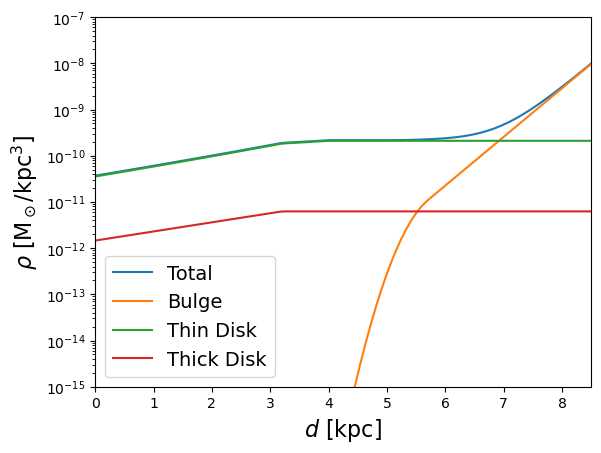

In [13]:
# Define values for the x-axis
d = np.linspace(0, rEarth, num=100)

# Calculate the density values for each component
rho_total_arr = [rho_FFPs(i) for i in d]
rho_bulge_arr = [rho_bulge(i) for i in d]
rho_thin_arr = [rho_thin(r_MW(i), 0.0) for i in d]
rho_thick_arr = [rho_thick(r_MW(i), 0.0) for i in d]

# Create the log plot
plt.plot(d, rho_total_arr, label="Total")
plt.plot(d, rho_bulge_arr, label="Bulge")
plt.plot(d, rho_thin_arr, label="Thin Disk")
plt.plot(d, rho_thick_arr, label="Thick Disk")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xlim(0, rEarth)
plt.ylim(1e-15, 1e-7)

# Show the plot
plt.show()


In [14]:
from scipy.integrate import nquad

In [127]:
def mass_enclosed(r: float, # distance from MW center in kpc
                  ) -> float:
        """Mass enclosed within a given distance from the Milky Way center assuming NFW profile
        Returns:
            float: mass in Msol
        """
        return 4*np.pi * rhoc * rs**3 * (np.log(1 + r/rs) - (r/rs)/(1 + r/rs))

def velocity_dispersion(d: float # distance from Sun in kpc
                        ) -> float:
        """PBH velocity dispersion at a given distance from the Milky Way center
        Returns:
                float: PBH velocity dispersion in km/s
        """
        r = r_MW(d)
        return np.sqrt(G * mass_enclosed(r) / r) 

def dist(
        d: float # distance from the Sun
        ) -> float:
        return d * (1 - d/ds)

def einstein_rad(d: float, # distance from the Sun
             mass: float = 1e-3 # mass of lens in solar masses
                ) -> float:
        return np.real((4 * G * mass * dist(d)/c**2)**(1/2))

def velocity_radial(d: float, # distance from the Sun
                umin: float, # minimum impact parameter
                t: float, # crossing time
                mass: float = 1e-3, # mass of lens in solar masses
                ) -> float:
        """
        PBH radial velocity at a given distance from the Sun
        """
        return 2*einstein_rad(d, mass) * (ut**2 - umin**2)**(1/2) / t * kpctokm

In [128]:
options = {"epsabs": 1e-10, "epsrel": 1e-10}

def dGdt_FFP(t, mFFP):
    def integrand(umin, d):
        return 1 / (ut**2 - umin**2)**(1/2) * rho_FFPs(d) / \
               (mFFP * velocity_dispersion(d)**2) * velocity_radial(d, umin, t * htosec, mFFP)**4 * \
               (htosec / kpctokm)**2 * np.exp(-velocity_radial(d, umin, t * htosec, mFFP)**2 / velocity_dispersion(d)**2)
    result, _ = nquad(integrand, [(0, ut), (0, rEarth)], opts=options)
    return 2 * result

In [221]:
mFFP = 1e-3
t = np.logspace(0, 4, num=100)
ffp_diff_rates = [dGdt_FFP(i, mFFP) for i in t]

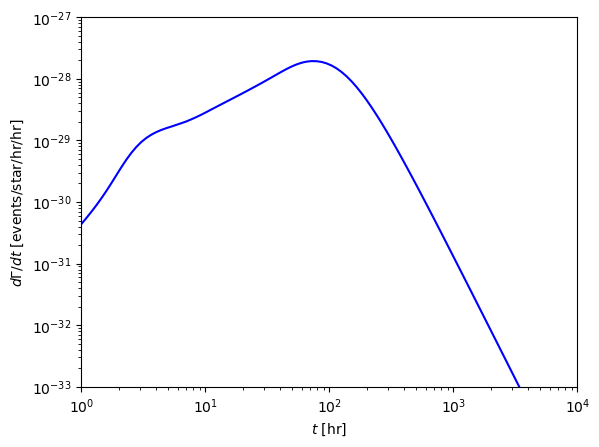

In [222]:
plt.loglog(t, ffp_diff_rates, 
           label="Event Rate", color="blue")
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e0, 1e4)
plt.ylim(1e-33, 1e-27)
plt.show()


## Perform Weighted Sum over FFP distribution

In [155]:
mMin = 1e-5  # solar masses
mMax = 1e-2
alpha = 2
nFFPs = 1e4
nBins = 10
tMin = 1e-2  # hours
tMax = 1e3
ntBins = 10

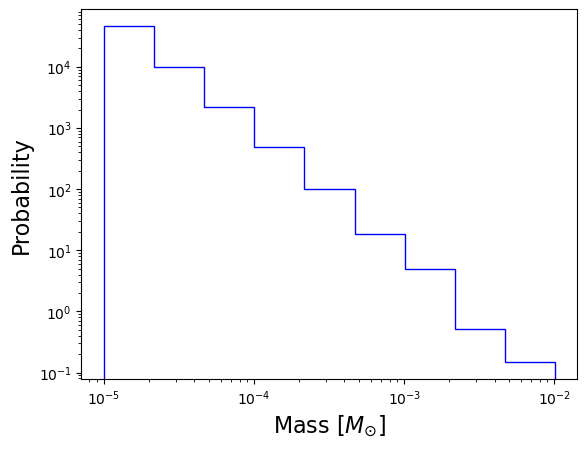

In [220]:
mSample = mMin * (1 - np.random.rand(int(nFFPs)))**(-1 / (alpha - 1))
tBins = np.logspace(np.log10(tMin), np.log10(tMax), num=ntBins)
bins = np.logspace(np.log10(mMin), np.log10(mMax * 1.01), num=nBins)
hist, bins = np.histogram(mSample, bins=bins, density=True)
plt.hist(mSample, bins=bins, density=True, histtype="step", color="blue")
plt.xlabel("Mass [$M_{\odot}$]", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
counts, hist_bins, = np.histogram(mSample, bins=bins, density=True)
bin_centers = (hist_bins[1:] + hist_bins[:-1]) / 2
ffpPDF = np.zeros((len(counts), len(bin_centers)))
ffpPDF[0] = counts/np.sum(counts)
ffpPDF[1] = bin_centers

In [207]:
from scipy.interpolate import interp1d

tETable = np.zeros((len(ffpPDF[0])-1, len(tBins)))
for i in range(len(ffpPDF[0])-1):
    for j in range(len(tBins)):
        tETable[i,j] = ffpPDF[0][i] * dGdt_FFP(tBins[j], ffpPDF[1][i])

In [216]:
tEWeighted = np.sum(tETable, axis=0)
tEInterp = interp1d(np.log10(tBins), np.log10(tEWeighted), kind="cubic")

In [217]:
t = np.logspace(-2, np.log10(5e1), num=100)
weighted_rate = 10**tEInterp(np.log10(t))

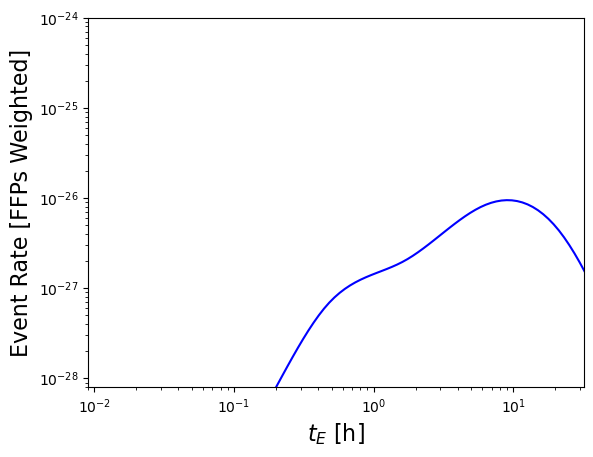

In [219]:
plt.loglog(t, weighted_rate, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel("Event Rate [FFPs Weighted]", fontsize=16)
plt.xlim([0.009, 32])
plt.ylim([8e-29, 1e-24])
plt.show()


In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()